In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, Flatten
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")




In [3]:
!pip install tensorflow_text
import tensorflow_text as text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.5 MB/s eta 0:00:00


## Read Dataset

[https://github.com/savan77/EmotionDetectionBERT/tree/master](https://github.com/savan77/EmotionDetectionBERT/tree/master)

In [4]:
train_data = pd.read_csv("https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_train.csv")
valid_data = pd.read_csv("https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_valid.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_test.csv")
train_data.head()


,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,He was answering a question about the criticis...,1,0,1,0,0,0,0,1,0,0,0,0
1,1,I'm going to start today's discussion thread w...,1,1,1,1,0,0,0,1,0,0,0,0
2,2,"By announcing the 395 self-quarantined, it pai...",1,1,1,1,0,0,0,1,0,0,0,0
3,3,"Likewise, sorry if I offended you. I’m not act...",1,0,1,1,0,0,0,1,0,0,0,0
4,4,"People infected by experience high fever, coug...",0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
train_setiment_data = train_data.dropna()
train_setiment_data = train_setiment_data.reset_index(drop=True)

valid_setiment_data = valid_data.dropna()
valid_setiment_data = valid_setiment_data.reset_index(drop=True)

test_setiment_data = test_data.dropna()
test_setiment_data = test_setiment_data.reset_index(drop=True)

label_class = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust", "neutral"]

input_data_train = train_setiment_data["text"].values
label_data_train = train_setiment_data[label_class].values


input_data_valid = valid_setiment_data["text"].values
label_data_valid = valid_setiment_data[label_class].values


input_data_test = test_setiment_data["text"].values
label_data_test = test_setiment_data[label_class].values


print("Input Train data SHAPE ", input_data_train.shape)
print("label Train data SHAPE ", label_data_train.shape)
print("Input valid data SHAPE ", input_data_valid.shape)
print("label valid data SHAPE ", label_data_valid.shape)
print("Input Test data SHAPE ", input_data_test.shape)
print("Label Test data SHAPE ", label_data_test.shape)



Input Train data SHAPE  (1493,)
label Train data SHAPE  (1493, 12)
Input valid data SHAPE  (165,)
label valid data SHAPE  (165, 12)
Input Test data SHAPE  (374,)
Label Test data SHAPE  (374, 12)


## TRaining with Pretrain Word Emebedding
Token based text embedding trained on ENglish Google News 7b Corpus

In [6]:
from keras.metrics import BinaryAccuracy

embedding = "https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim128/versions/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable = True)
model = Sequential()
model.add(hub_layer)
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(12, activation = 'sigmoid'))
model.summary()

adam = Adam(learning_rate = 0.001)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = BinaryAccuracy(
     name='binary_accuracy', dtype=None, threshold=0.5
))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 124647548 (475.49 MB)
Trainable params: 124647548 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint

callback_model = ModelCheckpoint('model_gooogle_embedding.h5', monitor = 'val_loss')
history = model.fit(
    x = input_data_train, y =label_data_train,
    epochs = 50,
    validation_data = (input_data_valid, label_data_valid),
    callbacks = [callback_model]
)

Epoch 1/50
47/47 [==============================] - 38s 636ms/step - loss: 0.6521 - binary_accuracy: 0.6580 - val_loss: 0.6035 - val_binary_accuracy: 0.7116
Epoch 2/50
47/47 [==============================] - 14s 308ms/step - loss: 0.5599 - binary_accuracy: 0.7353 - val_loss: 0.5210 - val_binary_accuracy: 0.7606
Epoch 3/50
47/47 [==============================] - 22s 474ms/step - loss: 0.4908 - binary_accuracy: 0.7748 - val_loss: 0.4509 - val_binary_accuracy: 0.8025
Epoch 4/50
47/47 [==============================] - 15s 312ms/step - loss: 0.4199 - binary_accuracy: 0.8265 - val_loss: 0.3663 - val_binary_accuracy: 0.8652
Epoch 5/50
47/47 [==============================] - 16s 354ms/step - loss: 0.3476 - binary_accuracy: 0.8593 - val_loss: 0.2995 - val_binary_accuracy: 0.8889
Epoch 6/50
47/47 [==============================] - 16s 346ms/step - loss: 0.2905 - binary_accuracy: 0.8842 - val_loss: 0.2510 - val_binary_accuracy: 0.9101
Epoch 7/50
47/47 [==============================] - 22s 48

In [8]:
model.load_weights('model_gooogle_embedding.h5')
model.evaluate(input_data_test, label_data_test)

preds = model.predict(input_data_test)
preds = tf.round(preds)
print(classification_report(label_data_test, preds, target_names = label_class, zero_division = 0))


12/12 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

       anger       0.59      0.45      0.51       121
anticipation       0.65      0.73      0.69       218
     disgust       0.69      0.61      0.65       156
        fear       0.68      0.65      0.66       195
         joy       0.43      0.14      0.22        70
        love       0.22      0.07      0.10        30
    optimism       0.34      0.73      0.46        97
   pessimism       0.46      0.51      0.48       120
     sadness       0.49      0.26      0.34       136
    surprise       0.29      0.04      0.07        49
       trust       0.38      0.27      0.31        60
     neutral       0.38      0.13      0.20        38

   micro avg       0.55      0.49      0.52      1290
   macro avg       0.47      0.38      0.39      1290
weighted avg       0.54      0.49      0.50      1290
 samples avg       0.51      0.47      0.45      1290



## Train with Bert

In [9]:
from keras import Model

def built_model_Bert():
  text_input = Input(shape=(), dtype = tf.string, name = 'text')
  preprocessing_layer = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3", name ='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-128-a-2/versions/2", trainable=True, name = "Bert-encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = Dense(400, activation ='relu')(net)
  net = Dropout(0.1)(net)
  net = Dense(200, activation ='relu')(net)
  net = Dropout(0.1)(net)
  net = Dense(100, activation ='relu')(net)
  net = Dropout(0.1)(net)
  net = Dense(50, activation ='relu')(net)
  net = Dropout(0.1)(net)
  net = Dense(12, activation ='sigmoid', name = 'classifier')(net)
  return Model(inputs = text_input, outputs = net)

classifier_model = built_model_Bert()
classifier_model.summary()
adam = Adam(learning_rate = 0.01)
metrc_acc = BinaryAccuracy(name="binary_accuracy", dtype= None, threshold = 0.5)
classifier_model.compile(optimizer = adam, loss ='binary_crossentropy', metrics = metrc_acc)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [13]:
callback_model_bert = ModelCheckpoint('model_small_Bert.h5', monitor = 'val_loss')
history = classifier_model.fit(
    x = input_data_train, y =label_data_train,
    epochs = 10,
    validation_data = (input_data_valid, label_data_valid),
    callbacks = [callback_model_bert]
)

Epoch 1/10
47/47 [==============================] - 55s 293ms/step - loss: 0.5720 - binary_accuracy: 0.6975 - val_loss: 0.5510 - val_binary_accuracy: 0.6990
Epoch 2/10
47/47 [==============================] - 12s 251ms/step - loss: 0.5503 - binary_accuracy: 0.7110 - val_loss: 0.5437 - val_binary_accuracy: 0.7045
Epoch 3/10
47/47 [==============================] - 11s 231ms/step - loss: 0.5486 - binary_accuracy: 0.7130 - val_loss: 0.5427 - val_binary_accuracy: 0.7045
Epoch 4/10
47/47 [==============================] - 12s 263ms/step - loss: 0.5421 - binary_accuracy: 0.7143 - val_loss: 0.5421 - val_binary_accuracy: 0.6990
Epoch 5/10
47/47 [==============================] - 10s 220ms/step - loss: 0.5415 - binary_accuracy: 0.7126 - val_loss: 0.5400 - val_binary_accuracy: 0.7045
Epoch 6/10
47/47 [==============================] - 10s 219ms/step - loss: 0.5408 - binary_accuracy: 0.7134 - val_loss: 0.5423 - val_binary_accuracy: 0.6990
Epoch 7/10
47/47 [==============================] - 9s 193

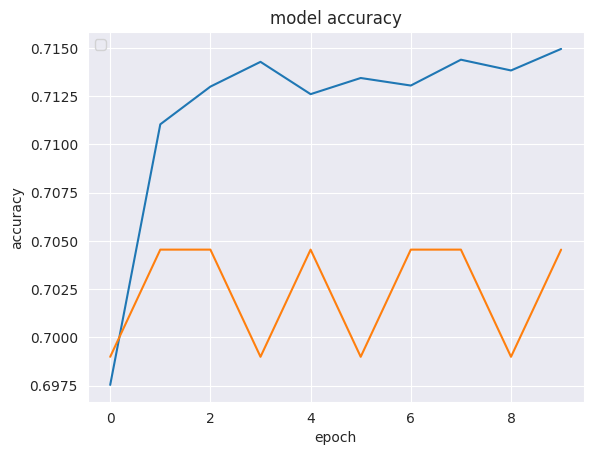

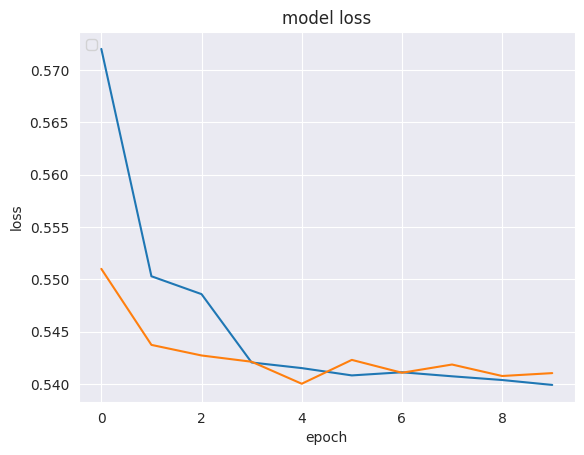

In [14]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend("train", "val", loc = "upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend("train", "val", loc = "upper left")
plt.show()

In [15]:
classifier_model.load_weights('model_small_Bert.h5')
classifier_model.evaluate(input_data_test, label_data_test)

preds = model.predict(input_data_test)
preds = tf.round(preds)
print(classification_report(label_data_test, preds, target_names = label_class, zero_division = 0))


12/12 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

       anger       0.60      0.48      0.53       121
anticipation       0.65      0.78      0.71       218
     disgust       0.64      0.70      0.67       156
        fear       0.62      0.79      0.70       195
         joy       0.48      0.14      0.22        70
        love       0.14      0.03      0.05        30
    optimism       0.34      0.66      0.45        97
   pessimism       0.44      0.75      0.56       120
     sadness       0.48      0.40      0.44       136
    surprise       0.31      0.08      0.13        49
       trust       0.45      0.23      0.31        60
     neutral       0.44      0.11      0.17        38

   micro avg       0.54      0.57      0.55      1290
   macro avg       0.47      0.43      0.41      1290
weighted avg       0.53      0.57      0.53      1290
 samples avg       0.52      0.53      0.49      1290



In [32]:

text_input = '''
Tai was extremely angry because his girlfriend fell in love with another man,
              that's why he was very sad the next day and at the same time he lost faith in life
'''
def predict_sentiment(input, output):
  pred_result = classifier_model.predict([text_input])
  pred_results = list(round(pred_result).numpy()[0])
  for v, l in zip(pred_results, label_class):
    if v == 1.0:
        print(l)

predict_sentiment(text_input, classifier_model)


1/1 [==============================] - 0s 65ms/step
anticipation


In [33]:
import pickle

filename = 'emotionDETECTION.sav'
pickle.dump(classifier_model, open(filename, 'wb'))
